In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from torchvision.transforms import v2
import torchvision
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, NonGeoDataset, IntersectionDataset, stack_samples, unbind_samples, random_bbox_assignment
from torchgeo.samplers import RandomGeoSampler, RandomBatchGeoSampler, GridGeoSampler
from torchgeo.datamodules import GeoDataModule
from torchgeo.datasets.utils import rgb_to_mask
import rasterio
from torchinfo import summary
import os
import re
import shutil
import kornia.augmentation as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

/home/edwmapa/miniconda3/envs/mlenv_nn/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
if torch.backends.mps.is_available():
	mps_device = torch.device("mps")
	x = torch.ones(1, device=mps_device)
	print(x)
elif torch.cuda.is_available():
	cuda_device = torch.device("cuda")
	x = torch.ones(1, device=cuda_device)
	print(x)

	print(torch.cuda.get_device_name(0))
	print('Memory Usage:')
	print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
	print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
	
else:
	print("MPS device not found.")

tensor([1.], device='cuda:0')
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
def plot_images(base_plot_size=4, **images):
	n = len(images)
	siz = base_plot_size * n
	fig, axs = plt.subplots(1,n, figsize=(siz, base_plot_size))

	for i, (name, image) in enumerate(images.items()):
		if n > 1:
			axs[i].set_title(name)
			axs[i].imshow(image)
			axs[i].axis('off')
		else:
			axs.set_title(name)
			axs.imshow(image)
	plt.tight_layout()

## Data loaders 

In [4]:
seg_map_cmap = [
	(255, 255, 255), # 0. Impervious Surfaces
  (0,0, 255), # 1. Building
  (0, 255, 255), # 2. Low Vegetation
  (0, 255, 0), # 3. Tree
  (255, 255, 0), # 4. Car
  (255, 0, 0), # 5. Clutter/background
]

In [5]:
# Dataset root paths
postdam_path = '../datasets/isprs/Potsdam/'

In [6]:
# Postdam quick fix - add CRS info to segmentation maps

reprocess_segmentation = False

if reprocess_segmentation:
	postdam_source_img_names = [f for f in os.listdir(os.path.join(postdam_path, '2_Ortho_RGB')) if re.match('.*.tif',f)]

	for filename in postdam_source_img_names:
		target_filename = re.sub(r'_RGB.tif$', '_label.tif', filename)
		source_raster = rasterio.open(os.path.join(postdam_path, '2_Ortho_RGB', filename), 'r')
		
		target_raster = rasterio.open(os.path.join(postdam_path, '5_Labels_all', target_filename), 'r')
		h = target_raster.height # 6000
		w = target_raster.width # 6000
		count = target_raster.count # 3
		dtype = target_raster.dtypes[0] # 'uint8'
		data = target_raster.read()
		target_raster.close()
		
		with rasterio.open(
			os.path.join(postdam_path, '5_Labels_all', target_filename),
			'w',
			driver='GTiff',
			height=h,
			width=w,
			count=count,
			dtype=dtype,
			crs=source_raster.crs,
			transform=source_raster.transform,
		) as new_file:
			new_file.write(data)

	del data

In [7]:
def invserse_cmap(image, cmap):
  return torch.tensor(cmap)[image.numpy()].permute(2, 0, 1)

def onehot_mask(img, cmap):
	img = img.permute(1, 2, 0)	
	mask = torch.zeros(img.shape[:2], dtype=torch.int64)
	for i, c in enumerate(cmap):
		cmask = img == torch.tensor(c)
		mask[cmask.all(axis=-1)] = i
	img = F.one_hot(mask).permute(2, 0, 1)
	return img

In [8]:
class RGBLoader(RasterDataset):
	filename_glob = '*.tif'
	is_image=True
	separate_files=False

class SegmentationMapLoader(RasterDataset):
	filename_glob = '*.tif'
	is_image=False # False means is a segmentation mask
	separate_files=False
	seg_map_cmap=seg_map_cmap
	one_hot=False

	def __getitem__(self, query):
		item = super().__getitem__(query)
		item['mask'] = item['mask'].permute(1, 2, 0)
		
		mask = torch.zeros(item['mask'].shape[:2], dtype=torch.int64)
		for i, c in enumerate(self.seg_map_cmap):
			cmask = item['mask'] == torch.tensor(c)
			mask[cmask.all(axis=-1)] = i

		item['mask'] = F.one_hot(mask).permute(2, 0, 1) if self.one_hot else mask.unsqueeze(0)
		return item


In [9]:
# Data Augmentation transforms
images_transforms = v2.Compose([
  v2.Resize(size=128),
  # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

segmentation_transforms = v2.Compose([v2.Resize(size=128, interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT)])

postdam_img_dataset = RGBLoader(os.path.join(postdam_path, '2_Ortho_RGB'), transforms=images_transforms)
postdam_seg_map_dataset = SegmentationMapLoader(os.path.join(postdam_path, '5_Labels_all'), transforms=segmentation_transforms)

# dataset = postdam_img_dataset & postdam_seg_map_dataset # Intersection Dataset
dataset = IntersectionDataset(postdam_img_dataset, postdam_seg_map_dataset)

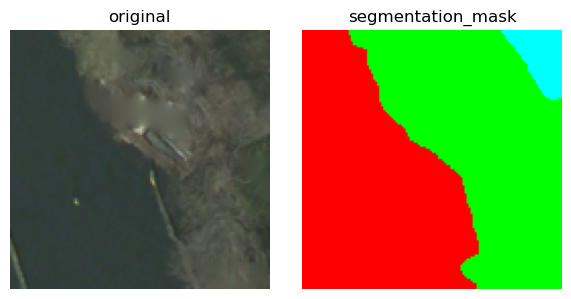

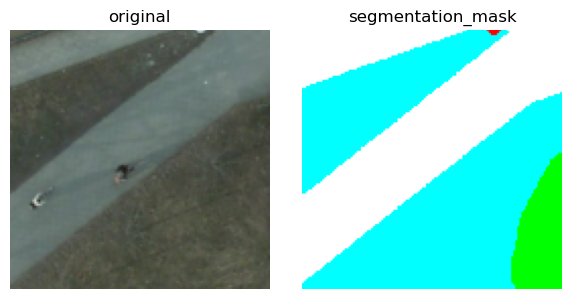

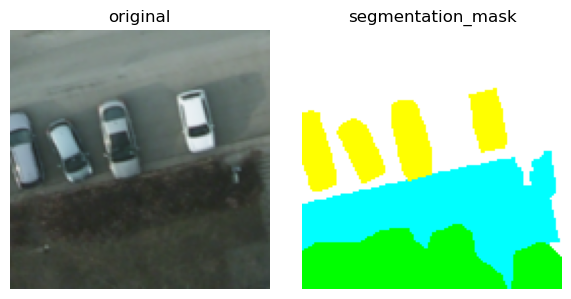

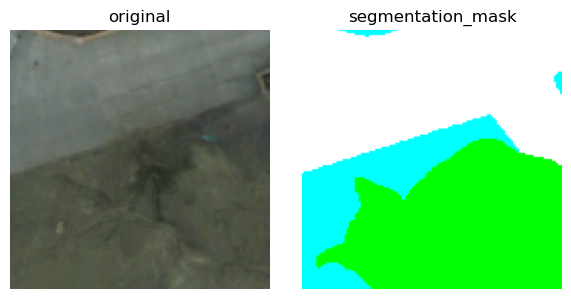

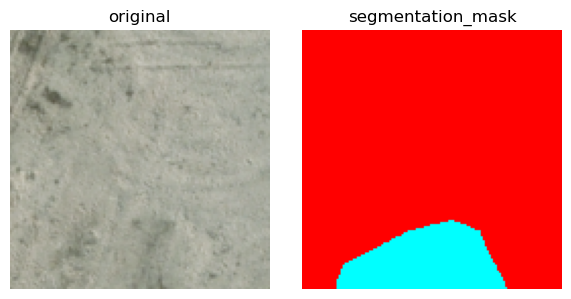

In [10]:
sampler = RandomGeoSampler(dataset, size=300, length=10) # patches of size 256, but resized by the transforms above
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

n=0
for sample in dataloader:
	if n==5: break
	
	image, gt = sample['image'], invserse_cmap(sample['mask'].squeeze(), seg_map_cmap)
	# image, gt = global_transforms(image, gt)

	plot_images(
		base_plot_size=3,
		original=v2.ToPILImage(mode='RGB')(image.squeeze()/255),
		segmentation_mask=v2.ToPILImage(mode='RGB')(gt/255),
	)
	n+=1

In [11]:
sample['mask'].shape

torch.Size([1, 1, 128, 128])

Lightning DataModule (GeoDataModule)

## Model (U-Net)

**Paper:** https://arxiv.org/pdf/1505.04597v1

**Related Readings:**
* Skip connections: https://theaisummer.com/skip-connections/
* Skip connections(cont.): https://www.analyticsvidhya.com/blog/2021/08/all-you-need-to-know-about-skip-connections/
* Segmentation Intro: https://www.jeremyjordan.me/semantic-segmentation/
* Satellital Imagery segmentation: https://towardsdatascience.com/u-net-for-semantic-segmentation-on-unbalanced-aerial-imagery-3474fa1d3e56/
* Convolution visualization: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md (useful to see how the upsampling transposed convolution works)
* Batch Norm: https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739/

Other Implementations:
* https://github.com/milesial/Pytorch-UNet

Unet Architecture looks like this:

<img src="https://towardsdatascience.com/wp-content/uploads/2021/10/1eQLQo43suhzuHslqy-LL3g.png" width="800">

The key elements of a step in the "contraction" path of the architecture are:
* Double 3x3 convolutions at every step
* After the double convolutions, it has a 2x2 max pooling with stride 2 for downsampling
* After each downsample, the number of channels are doubled

The key elements of a step in the "expansive" path of the architecture are:
* 2x2 up-convolution that halves the number of channels (upscaling)
* We concatenate the corresponding feature maps of the contraction path to the upscaled maps.
  * Keep in mind that the concatenated maps are cropped because we miss border pixels on each convolution
  * Some authors handle the border issues by extending/reflecting/padding the images.
* We apply double 3x3 convolutions before the next upscaling.

At the end we apply a 1x1 convolution layer to map the resulting feature maps to the desired number of classes

In [12]:
# Double convolution block
class BlockConvolution(nn.Module):
	def __init__(self, in_channels, out_channels):
		super().__init__()
		self.model = nn.Sequential(
			nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=True), # padding to avoid border issues
			nn.BatchNorm2d(out_channels), # Not required in the base architecture, but according to what we've read, it is useful to avoid gradient vanishing problems, stabilizes learning, etc.
			nn.ReLU(),
			nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=True),
			nn.BatchNorm2d(out_channels),
			nn.ReLU()
		)
	
	def forward(self, x):
		return self.model(x)


class DownBlock(nn.Module):
	def __init__(self, in_channels, out_channels):
		super().__init__()
		self.model = nn.Sequential(
			nn.MaxPool2d(2),
			BlockConvolution(in_channels, out_channels)
		)
	
	def forward(self, x):
		return self.model(x)


class UpBlock(nn.Module):
	def __init__(self, in_channels, out_channels):
		super().__init__()
		# Reduce the number of in_channels by half and upscale image by twice de dimension
		self.upscale = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

		# Conv (half of the in_channels come from the skip connections and the other half from the upscale)
		self.block_conv = BlockConvolution(in_channels, out_channels)

	def forward(self, x, x_skip):
		# x_skip are the weights of the corresponding down layer
		# Upscale
		x = self.upscale(x)
		
		# Pad upscaled (if necessary?)
		diffY = x_skip.size()[2] - x.size()[2]
		diffX = x_skip.size()[3] - x.size()[3]
		x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
		
		# Concat
		x = torch.cat([x_skip, x], dim=1)
		return self.block_conv(x)


class UNET(nn.Module):
	def __init__(self, in_channels, n_classes):
		super().__init__()
		
		self.contraction_layers = nn.ModuleList([
			BlockConvolution(in_channels, 64), # skips to D
			DownBlock(64, 128), # skips to C
			DownBlock(128, 256), # skips to B
			DownBlock(256, 512), # skips to A
			DownBlock(512, 1024), 
		])
		self.expansion_layers = nn.ModuleList([
			UpBlock(1024, 512), # A
			UpBlock(512, 256),  # B
			UpBlock(256, 128), # C
			UpBlock(128, 64) # D
		])
		self.out_layer = nn.Conv2d(64, n_classes, kernel_size=1) # Logits

	def forward(self, x):
		# Contraction
		x_c = [self.contraction_layers[0](x)]
		for f in self.contraction_layers[1:]:
			x_c.append(f(x_c[-1]))

		# Expansion
		x = self.expansion_layers[0](x_c[-1], x_c[-2]) # (x_to_upscale, skip_values)
		for i, f in enumerate(self.expansion_layers[1:]):
			skip_idx = len(self.contraction_layers) - 3 - i 
			x = f(x, x_c[skip_idx])
		
		x = self.out_layer(x)
		return x

In [13]:
# Test forward
test = UNET(3, len(seg_map_cmap))
test_in = torch.randn(2, 3, 128, 128)
test_out = test(test_in)

print(test_in.shape)
print(test_out.shape)
print("n_classes:", len(seg_map_cmap))

del test, test_in, test_out

torch.Size([2, 3, 128, 128])
torch.Size([2, 6, 128, 128])
n_classes: 6


Define Lightning Module and DataModule

In [14]:
# Read: https://medium.com/data-scientists-diary/implementation-of-dice-loss-vision-pytorch-7eef1e438f68
# Implementing dice loss, useful for unbalanced dataset
def multiclass_dice_loss(pred, target, smooth=1):
	"""
	Computes Dice Loss for multi-class segmentation.
	Args:
		pred: Tensor of predictions (batch_size, C, H, W).
		target: One-hot encoded ground truth (batch_size, C, H, W).
		smooth: Smoothing factor.
	Returns:
		Scalar Dice Loss.
	"""
	pred = F.softmax(pred, dim=1)  # Convert logits to probabilities
	num_classes = pred.shape[1]  # Number of classes (C)
	dice = 0  # Initialize Dice loss accumulator
	
	for c in range(num_classes):  # Loop through each class
		pred_c = pred[:, c]  # Predictions for class c
		target_c = target[:, c]  # Ground truth for class c
		
		intersection = (pred_c * target_c).sum(dim=(1, 2))  # Element-wise multiplication
		union = pred_c.sum(dim=(1, 2)) + target_c.sum(dim=(1, 2))  # Sum of all pixels
		
		dice += (2. * intersection + smooth) / (union + smooth)  # Per-class Dice score

	return 1 - dice.mean() / num_classes


class UNETModel(L.LightningModule):
	def __init__(
		self,
		image_size=128,
		cmap=seg_map_cmap,
		lr=1e-3,
		epochs=30,
		warmup_epochs=10,
	):
		super().__init__()
		self.model = UNET(in_channels=3, n_classes=len(cmap))
		
		self.cmap = cmap
		self.n_classes = len(cmap)
		self.image_size=image_size
		self.lr = lr
		self.epochs=epochs
		self.warmup_epochs=warmup_epochs
		self.save_hyperparameters()

	def forward(self, x):
		return self.model(x)
		
	def training_step(self, batch, batch_idx):
		x = batch['image'] / 255 # normalize, it was not normalized, and I don't wan't to fiddle more with the transforms, I'm tired!!!!!
		y = batch['mask'] # Not normalized
		y_pred = self(x)

		crossentropy = F.cross_entropy(y_pred.squeeze(1), y) # Crossentropy
		dice = multiclass_dice_loss(
			y_pred.squeeze(1),
			F.one_hot(y, self.n_classes).permute(0, 3, 1, 2)
		) # Dice
		loss = crossentropy + dice

		self.log("train_crossentropy", crossentropy, prog_bar=True, on_step=False, on_epoch=True)
		self.log("train_dice", dice, prog_bar=True, on_step=False, on_epoch=True)
		self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
		return loss

	def validation_step(self, batch, batch_idx):
		x = batch['image'] / 255
		y = batch['mask']
		
		y_pred = self(x)
		crossentropy = F.cross_entropy(y_pred.squeeze(1), y) # Crossentropy
		dice = multiclass_dice_loss(
			y_pred.squeeze(1),
			F.one_hot(y, self.n_classes).permute(0, 3, 1, 2)
		) # Dice
		loss = crossentropy + dice

		self.log("val_crossentropy", crossentropy, prog_bar=True, on_step=False, on_epoch=True)
		self.log("val_dice", dice, prog_bar=True, on_step=False, on_epoch=True)
		self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
		return loss
	
	@torch.no_grad()
	def test_step(self, batch, batch_idx):
		x = batch['image'] / 255
		y = batch['mask']
		
		y_pred = self(x)

		crossentropy = F.cross_entropy(y_pred.squeeze(1), y) # Crossentropy
		dice = multiclass_dice_loss(
			y_pred.squeeze(1),
			F.one_hot(y, self.n_classes).permute(0, 3, 1, 2)
		) # Dice
		loss = crossentropy + dice

		self.log("test_crossentropy", crossentropy, prog_bar=True, on_step=False, on_epoch=True)
		self.log("test_dice", dice, prog_bar=True, on_step=False, on_epoch=True)
		self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
		return loss
	
	def on_train_epoch_start(self):
		# Log the learning rate
		optimizer = self.trainer.optimizers[0]
		lr = optimizer.param_groups[0]['lr']
		self.log('learning_rate', lr, on_epoch=True, prog_bar=True)

	def configure_optimizers(self):
		# optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
		optimizer = torch.optim.RMSprop(self.parameters(), lr=self.lr, weight_decay=1e-8, momentum=0.999, foreach=True)
		scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score

		return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "monitor": "val_loss",
            "frequency": 1
            # If "monitor" references validation metrics, then "frequency" should be set to a
            # multiple of "trainer.check_val_every_n_epoch".
        },
    }


In [15]:
class RGBLoader(RasterDataset):
	filename_glob = '*.tif'
	is_image=True
	separate_files=False

class SegmentationMapLoader(RasterDataset):
	filename_glob = '*.tif'
	is_image=False # False means is a segmentation mask
	separate_files=False
	seg_map_cmap=seg_map_cmap
	one_hot=False

	def __getitem__(self, query):
		item = super().__getitem__(query)
		item['mask'] = item['mask'].permute(1, 2, 0)
		
		mask = torch.zeros(item['mask'].shape[:2], dtype=torch.int64)
		for i, c in enumerate(self.seg_map_cmap):
			cmask = item['mask'] == torch.tensor(c)
			mask[cmask.all(axis=-1)] = i

		item['mask'] = F.one_hot(mask).permute(2, 0, 1) if self.one_hot else mask.unsqueeze(0)
		return item


class CustomGeoDataModule(GeoDataModule): # Geodamatodule extends from torch lightning DataModules
	def __init__(self, **kwargs):
		super().__init__(
			dataset_class=kwargs['dataset_class'],
			batch_size=kwargs['batch_size'],
			patch_size=kwargs['patch_size'],
			length=kwargs['length'],
			num_workers=kwargs['num_workers'],
			**kwargs['dataset_class_kwargs']
		)
		# keep in mind that super method will set kwargs object attribute as kwargs['dataset_class_kwargs']
		self.split_faction = kwargs.get('split_fraction', [0.6, 0.2, 0.2]) # train, validate, test
		self.seed = kwargs.get('seed')

	def setup(self, stage):
		# self.dataset = self.dataset_class(**self.kwargs)
		self.dataset = self.kwargs['dataset1'] & self.kwargs['dataset2']

		generator = torch.Generator().manual_seed(self.seed)
		(self.train_dataset, self.val_dataset, self.test_dataset) = random_bbox_assignment(self.dataset, self.split_faction, generator)

		if stage in ["fit"]:
			self.train_batch_sampler = RandomBatchGeoSampler(self.train_dataset, self.patch_size, self.batch_size, self.length)
		if stage in ["fit", "validate"]:
			self.val_sampler = GridGeoSampler(self.val_dataset, self.patch_size, self.patch_size)
		if stage in ["test"]:
			self.test_sampler = GridGeoSampler(self.test_dataset, self.patch_size, self.patch_size)

## Training

In [18]:
patch_size = 300 # Patch size
sample_size = 500
batch_size = 16
n_workers = 4
split_fraction = [0.6, 0.2, 0.2] # train, validate, test


# Rescale factor
in_image_size = 128
out_image_size = 128

images_transforms = v2.Compose([
	v2.Resize(size=in_image_size),
])


segmentation_transforms = v2.Compose([
	v2.Resize(size=out_image_size, interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT),
])

postdam_img_dataset = RGBLoader(os.path.join(postdam_path, '2_Ortho_RGB'), transforms=images_transforms)
postdam_seg_map_dataset = SegmentationMapLoader(os.path.join(postdam_path, '5_Labels_all'), transforms=segmentation_transforms)

datamodule = CustomGeoDataModule(
	dataset_class = IntersectionDataset,
	batch_size = batch_size, # GeoDataModule kwargs
	patch_size = patch_size, # GeoDataModule kwargs
	length = sample_size, # GeoDataModule kwargs
	num_workers = n_workers, # GeoDataModule kwargs
	dataset_class_kwargs = dict(
		dataset1 = postdam_img_dataset, # IntersectionDataset kwargs
		dataset2 = postdam_seg_map_dataset, # IntersectionDataset kwargs
		collate_fn = stack_samples, # IntersectionDataset kwargs
	),
	split_fraction=split_fraction,
	seed=12345,
)

In [35]:
lr = 1e-4
epochs = 200
warmup_epochs = 10

model = UNETModel(
  image_size=in_image_size,
	cmap=seg_map_cmap,
	lr=lr,
	epochs=epochs,
	warmup_epochs=warmup_epochs,
)

summary(model.model, (1, 3, in_image_size, in_image_size), depth=3, device="cpu")

Layer (type:depth-idx)                             Output Shape              Param #
UNET                                               [1, 6, 128, 128]          --
├─ModuleList: 1-1                                  --                        --
│    └─BlockConvolution: 2-1                       [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1                        [1, 64, 128, 128]         38,976
│    └─DownBlock: 2-2                              [1, 128, 64, 64]          --
│    │    └─Sequential: 3-2                        [1, 128, 64, 64]          221,952
│    └─DownBlock: 2-3                              [1, 256, 32, 32]          --
│    │    └─Sequential: 3-3                        [1, 256, 32, 32]          886,272
│    └─DownBlock: 2-4                              [1, 512, 16, 16]          --
│    │    └─Sequential: 3-4                        [1, 512, 16, 16]          3,542,016
│    └─DownBlock: 2-5                              [1, 1024, 8, 8]           --
│    │    └─Se

In [36]:
out_path = './training_unet/t_3/'
if not os.path.exists(out_path):
	os.makedirs(out_path)

logger = pl_loggers.CSVLogger(
	out_path,
	name='train_logs'
)

checkpoint_callback = ModelCheckpoint(
	every_n_epochs=1,
	dirpath=out_path,
	filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}',
	save_last=True,
	save_top_k=5,
	monitor='val_loss',
	mode='min',
)

# early_stop_callback = EarlyStopping(
# 	monitor="val_loss",
# 	mode="min",
# 	patience=30,
# )

trainer = Trainer(
	max_epochs=epochs,
	accelerator='cuda',
	callbacks=[
		checkpoint_callback,
		# early_stop_callback
	],
	logger=logger,
	# fast_dev_run=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [37]:
trainer.fit(model, datamodule)

/home/edwmapa/miniconda3/envs/mlenv_nn/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/edwmapa/Git/Proj-Redes-Neuronales-2024/2_unet/training_unet/t_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNET | 31.0 M | train
---------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.175   Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


/home/edwmapa/miniconda3/envs/mlenv_nn/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 199: 100%|██████████| 31/31 [00:15<00:00,  2.04it/s, v_num=0, val_crossentropy=1.030, val_dice=0.733, val_loss=1.760, learning_rate=1e-8, train_crossentropy=1.110, train_dice=0.745, train_loss=1.850] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s, v_num=0, val_crossentropy=1.030, val_dice=0.733, val_loss=1.760, learning_rate=1e-8, train_crossentropy=1.110, train_dice=0.745, train_loss=1.850]


In [38]:
trainer.test(
  model=model,
  ckpt_path="last",
  datamodule=datamodule,
)

Restoring states from the checkpoint path at /home/edwmapa/Git/Proj-Redes-Neuronales-2024/2_unet/training_unet/t_3/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/edwmapa/Git/Proj-Redes-Neuronales-2024/2_unet/training_unet/t_3/last.ckpt


Testing DataLoader 0: 100%|██████████| 175/175 [00:08<00:00, 20.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test_crossentropy       1.0055854320526123
        test_dice           0.7319821715354919
        test_loss           1.7375675439834595
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_crossentropy': 1.0055854320526123,
  'test_dice': 0.7319821715354919,
  'test_loss': 1.7375675439834595}]

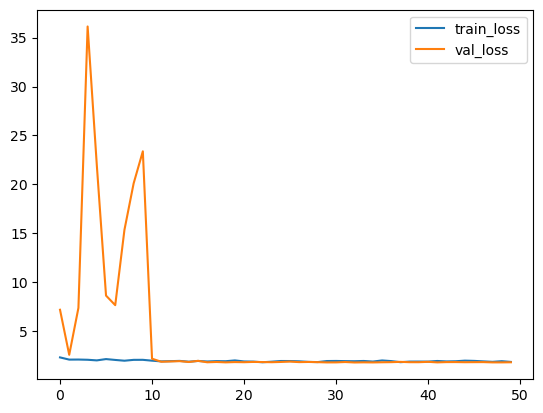

In [39]:
df = pd.read_csv('./training_unet/t_2/train_logs/version_0/metrics.csv')
df = df.groupby(['epoch']).max().reset_index()
plt.plot(df['epoch'], df['train_loss'], label='train_loss')
plt.plot(df['epoch'], df['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Eval

In [40]:
model = UNETModel.load_from_checkpoint(
  './training_unet/t_2/last.ckpt',
  image_size=in_image_size,
	cmap=seg_map_cmap,
	lr=lr,
	epochs=epochs,
	warmup_epochs=warmup_epochs,
).to('cuda')
model.eval()
print(model.device)

cuda:0


In [41]:
datamodule.setup('test')
dataloader= datamodule.test_dataloader()
iterator = iter(dataloader)

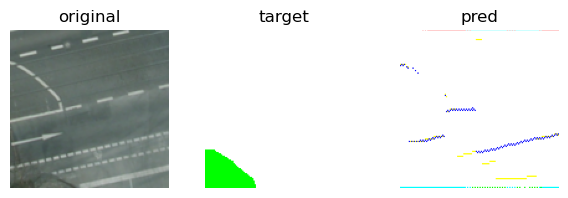

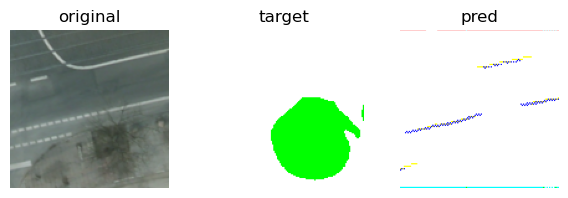

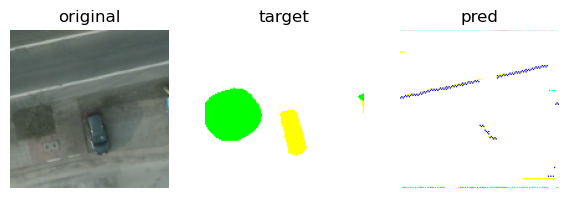

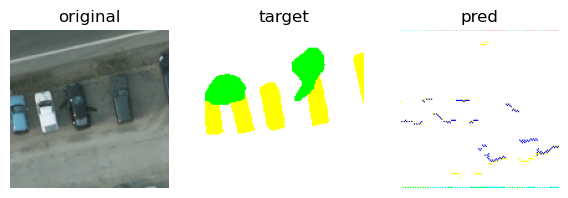

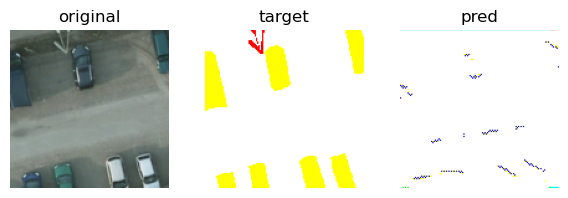

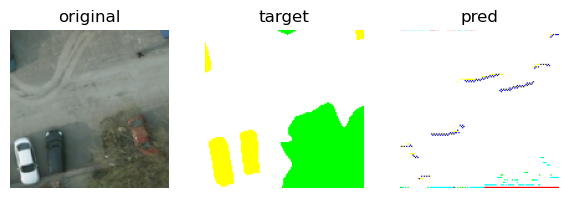

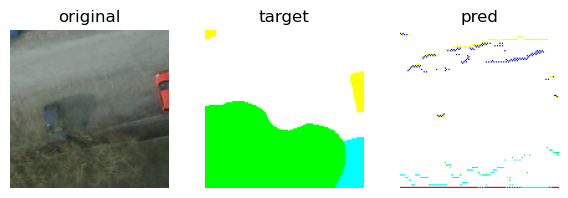

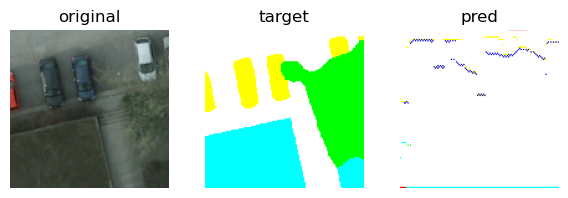

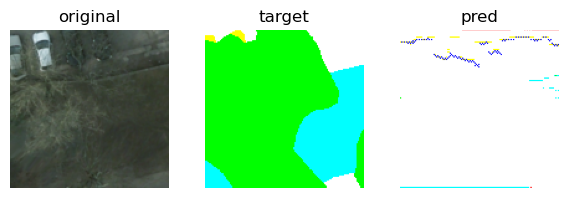

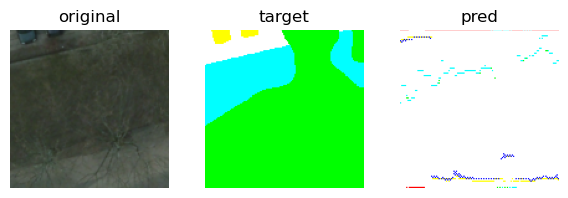

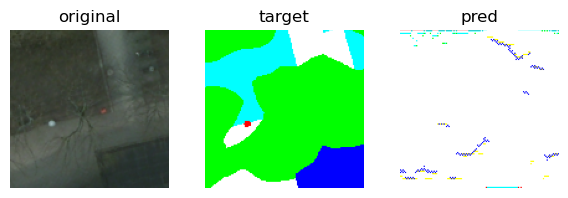

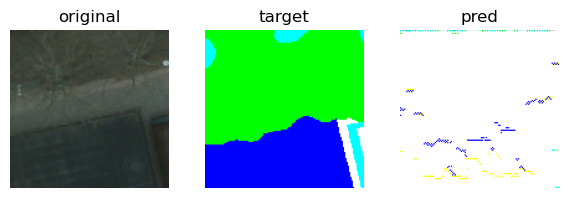

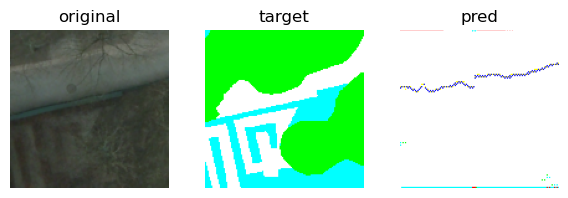

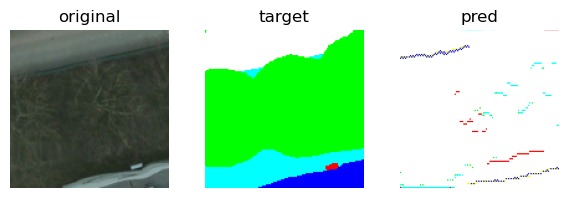

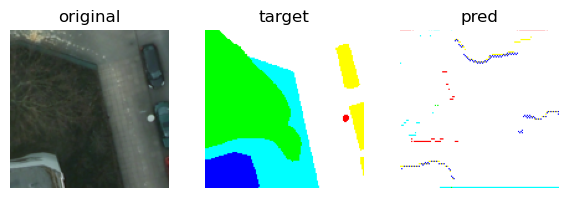

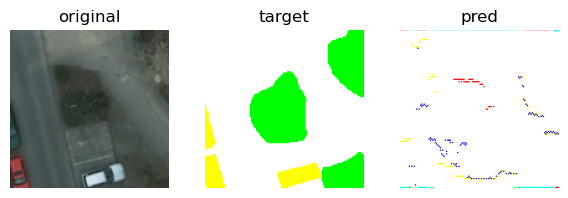

In [42]:
# TODO - Adapt
with torch.no_grad():
	batch = next(iterator)
	images = batch['image']
	masks = batch['mask']
	pred_masks = model(images.to('cuda'))

for image, mask, pred_mask in zip(images, masks, pred_masks):
	decoded_mask = invserse_cmap(mask.squeeze(), seg_map_cmap)
	decoded_pred = invserse_cmap(F.softmax(pred_mask, dim=1).permute(1,2,0).argmax(dim=2).cpu(), seg_map_cmap)
	
	
	plot_images(
		base_plot_size=2,
		original=v2.ToPILImage(mode='RGB')(image/255),
		target = v2.ToPILImage(mode='RGB')(decoded_mask/255),
		pred = v2.ToPILImage(mode='RGB')(decoded_pred/255),
	)